# Прогноз риска беременности

# Импорты библиотек


In [ ]:
!pip install phik

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    f1_score, accuracy_score, precision_score, recall_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve, average_precision_score, make_scorer)

from phik import phik_matrix
from phik.report import plot_correlation_matrix

RANDOM_STATE = 42
TEST_SIZE = 0.3

# Загрузка датасета

In [ ]:
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1--FeiK0Yo4GARky8s3OjujnXgOeicO1V")

df.shape

(1014, 7)

# Первичный просмотр сета и чистка

In [ ]:
def analyze_dataframe(df):
    total_rows = len(df)
    analysis = pd.DataFrame({
        'Missing Values': df.isnull().sum(),
        'Missing %': (df.isnull().sum() / total_rows * 100).round(2),
        'Data Type': df.dtypes,
        'Unique Values': df.nunique()})
    analysis.index.name = 'Column'

    display(df.head())
    display(df.describe().T)
    display(analysis)
    print(f"Количество дубликатов: {df.duplicated().sum()}")


analyze_dataframe(df)

Column,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


,count,mean,std,min,25%,50%,75%,max
Column,,,,,,,,
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


,Missing Values,Missing %,Data Type,Unique Values
Column,,,,
Age,0,0.0,int64,50
SystolicBP,0,0.0,int64,19
DiastolicBP,0,0.0,int64,16
BS,0,0.0,float64,29
BodyTemp,0,0.0,float64,8
HeartRate,0,0.0,int64,16
RiskLevel,0,0.0,object,3


Количество дубликатов: 562


In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(452, 7)

Значительное количество дубликатов (более 50%). Потребовалось удаление


# EDA + визуализация

Перед построением модели важно понять структуру данных: распределения признаков, наличие выбросов и потенциальные зависимости. Это поможет в выборе модели и её параметров

Вопросы, на которые мы будем искать ответы:
- Имеются ли выбросы в признаках, таких как давление или уровень сахара?
- Есть ли дисбаланс между уровнями риска?

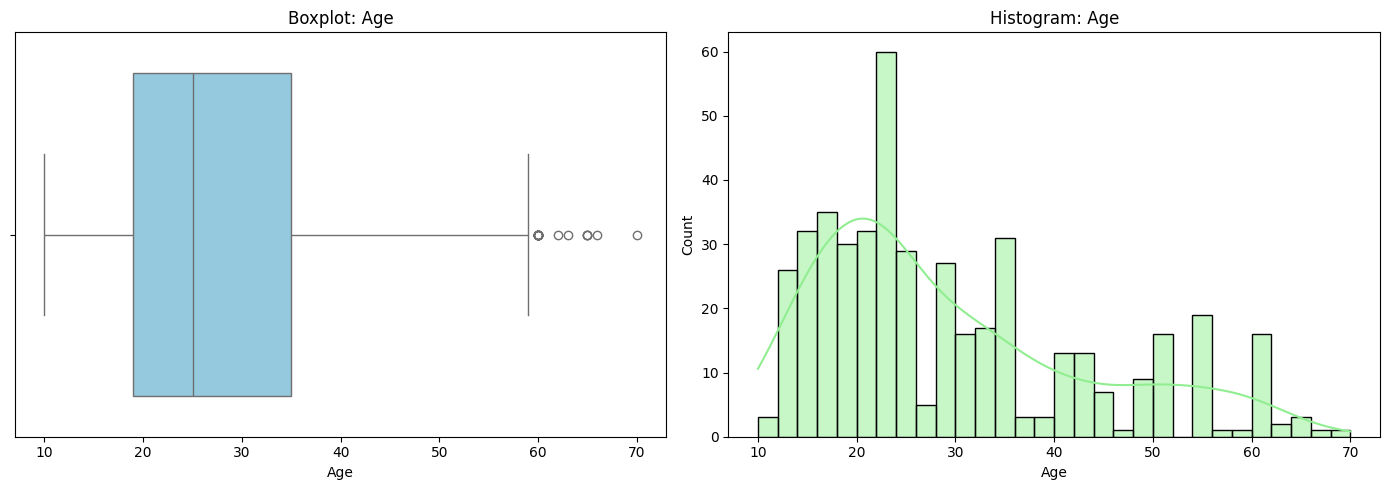

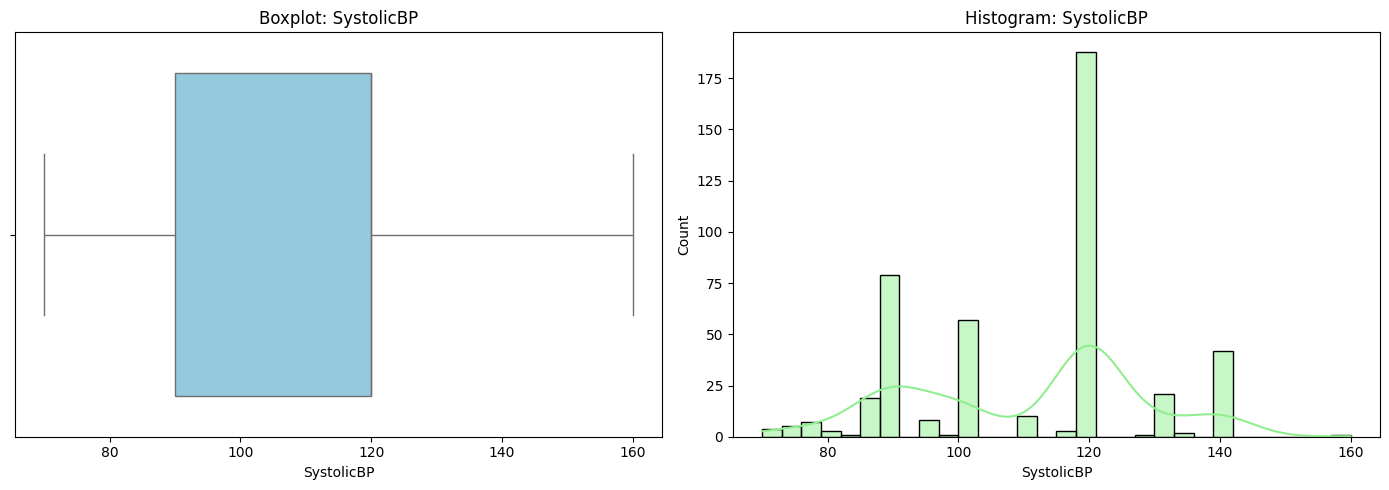

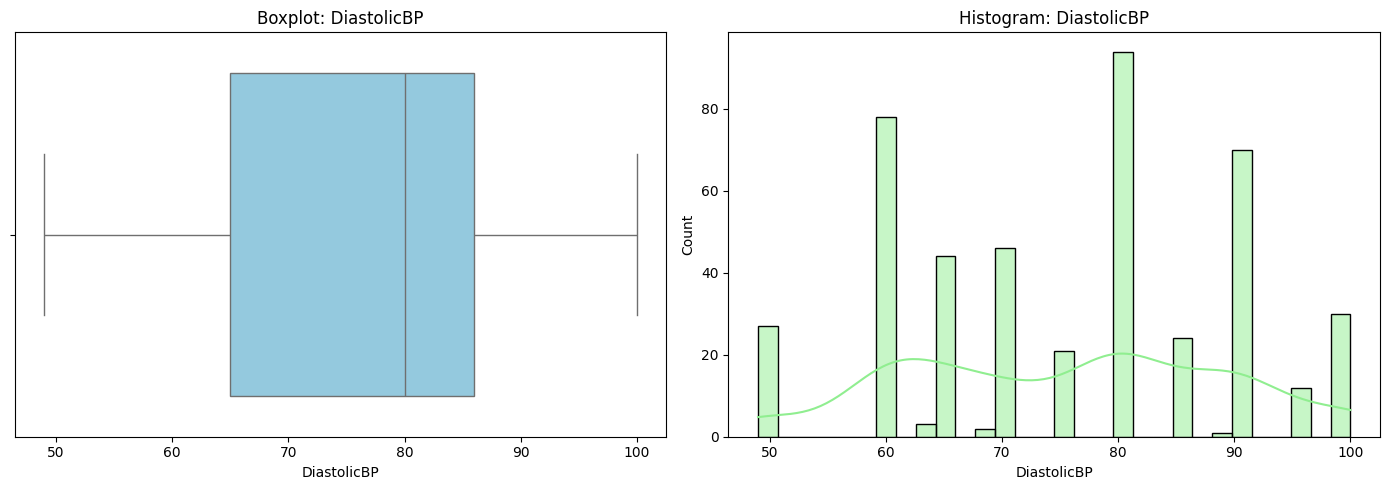

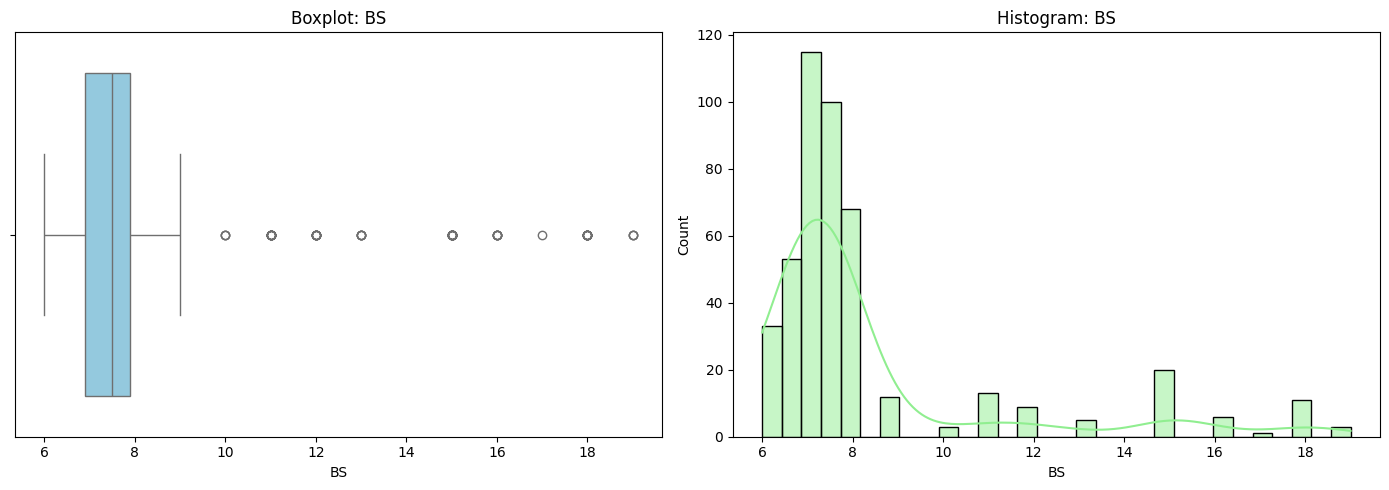

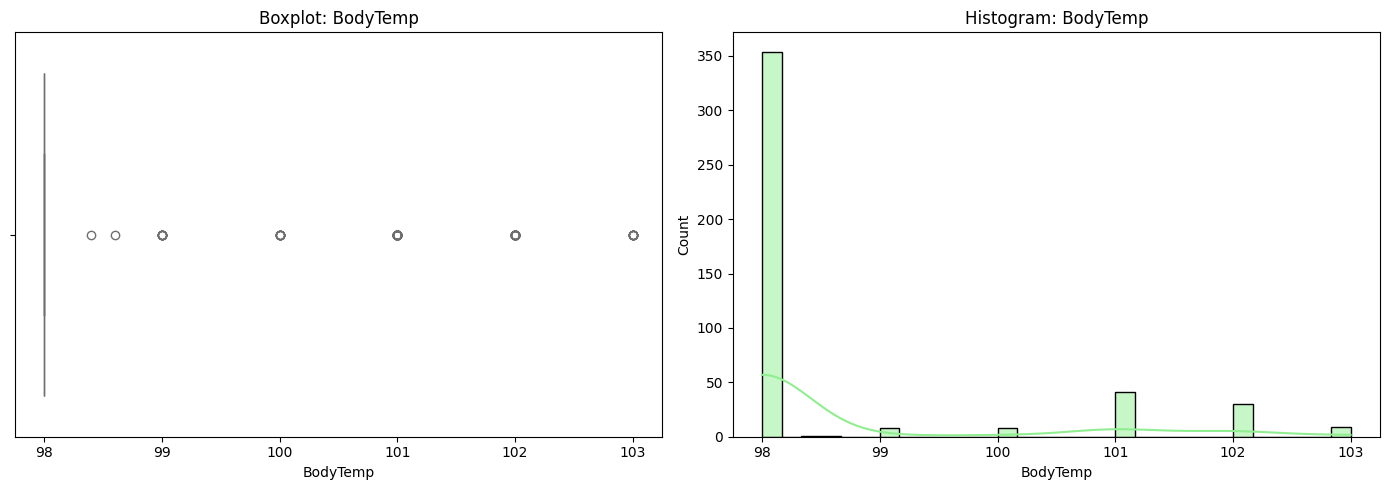

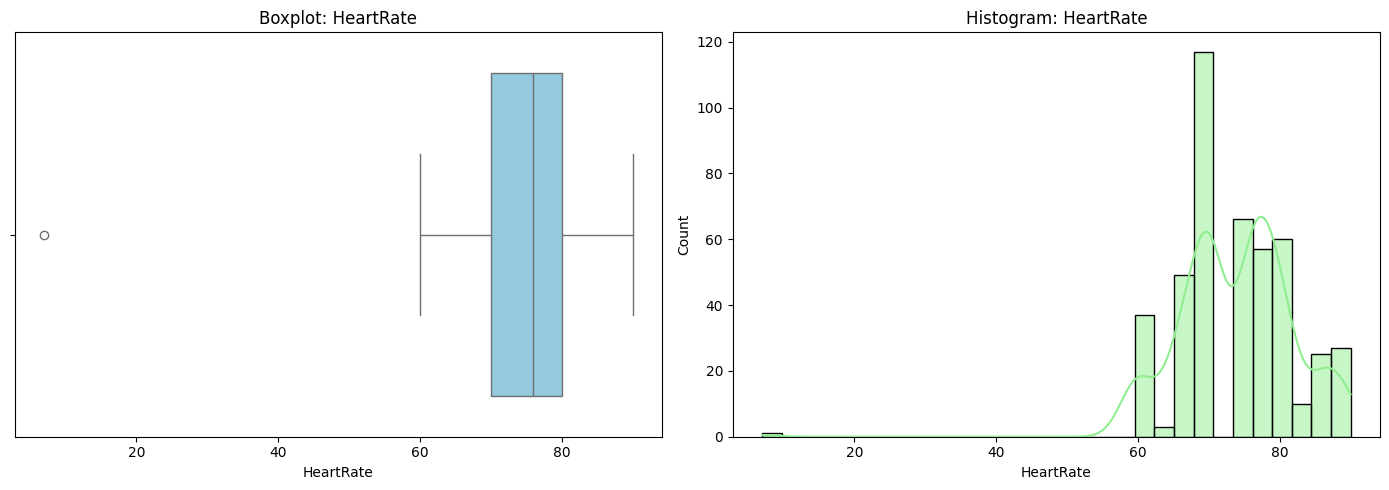

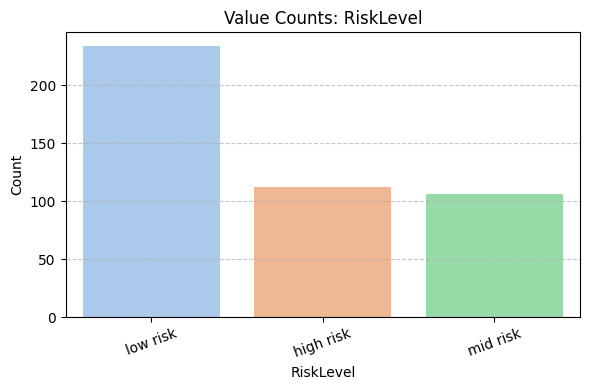

In [ ]:
def visualiation(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    for col in numeric_cols:
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        sb.boxplot(x=df[col], color='skyblue')
        plt.title(f'Boxplot: {col}')
        plt.subplot(1, 2, 2)
        sb.histplot(df[col], kde=True, bins=30, color='lightgreen')
        plt.title(f'Histogram: {col}')
        plt.tight_layout()
        plt.show()
        plt.close()

    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        sb.countplot(data=df, x=col, order=df[col].value_counts().index, palette='pastel')
        plt.title(f'Value Counts: {col}')
        plt.xticks(rotation=20)
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        plt.close()
visualiation(df)

In [ ]:
total = len(df)

print(f"Age < 12: {(df['Age'] < 12).sum()} строк ({(df['Age'] < 12).mean():.2%})")
print(f"BS > 16: {(df['BS'] > 16).sum()} строк ({(df['BS'] > 16).mean():.2%})")
print(f"BodyTemp > 102.5: {(df['BodyTemp'] > 102.5).sum()} строк ({(df['BodyTemp'] > 102.5).mean():.2%})")
print(f"HeartRate ≤ 30: {(df['HeartRate'] <= 30).sum()} строк ({(df['HeartRate'] <= 30).mean():.2%})")


Age < 12: 3 строк (0.66%)
BS > 16: 15 строк (3.32%)
BodyTemp > 102.5: 9 строк (1.99%)
HeartRate ≤ 30: 1 строк (0.22%)


In [ ]:
df = df[
    (df['Age'] >= 12) &
    (df['BodyTemp'] <= 102.5) &
    (df['HeartRate'] > 30) &
    (df['BS'] <= 15)]

df.shape

(418, 7)

- Наблюдается дисбаланс классов: большинство примеров относятся к low risk

Обоснования по каждому признаку:

- Age >= 12
Увидел, что в данных есть беременные младше 12 лет. Это довольно сомнительно — такие случаи крайне редки, поэтому решил такие записи удалить как потенциально ошибочные (их около 1%)

- BodyTemp <= 102.5 (≈39.2°C)
По всей видимости, температура указана в фаренгейтах. Значения выше 102.5°F выглядят как лихорадка или просто ошибки — таких записей мало, решил их исключить.

- HeartRate > 30
Пульс ниже 30 уд./мин — физиологически крайне редкий случай, потенциальная ошибка измерения или ввода.

- BS <= 15 (Blood Sugar)
Уровень сахара выше 15 — пограничные или экстренные состояния, часто признак Основная масса значений — в диапазоне 6–9, что отражает норму или допустимое отклонение

# Добавление фичей

In [ ]:
df['BP_Diff'] = df['SystolicBP'] - df['DiastolicBP']
df['PP_Ratio'] = df['BP_Diff'] / df['SystolicBP']

df['AgeGroup'] = pd.cut(
    df['Age'],
    bins=[12, 20, 30, 40, 50, float('inf')],
    labels=['12–20', '21–30', '31–40', '41–50', '51+'],
    right=True,
    include_lowest=True)

df['RiskLevel_encoded'] = df['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 451
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                418 non-null    int64   
 1   SystolicBP         418 non-null    int64   
 2   DiastolicBP        418 non-null    int64   
 3   BS                 418 non-null    float64 
 4   BodyTemp           418 non-null    float64 
 5   HeartRate          418 non-null    int64   
 6   RiskLevel          418 non-null    object  
 7   BP_Diff            418 non-null    int64   
 8   PP_Ratio           418 non-null    float64 
 9   AgeGroup           418 non-null    category
 10  RiskLevel_encoded  418 non-null    int64   
dtypes: category(1), float64(3), int64(6), object(1)
memory usage: 36.5+ KB


- BP_Diff = SystolicBP - DiastolicBP
Пульсовым давлением. В медицине это один из индикаторов индикаторов, слишком большое или маленькое значение может сигнализировать о рисках для сердечно-сосудистой системы


- PP_Ratio = BP_Diff / SystolicBP
Добавил новый признак — разницу между систолическим и диастолическим давлением. Это пульсовое давление, и оно часто используется врачами для оценки состояния сердца. Может оказаться полезным для модели.

- AgeGroup
Возраст сгруппирован в медицински обоснованные интервалы. Модели лучше справляются с интерпретацией категорий, чем с числовыми границами, особенно для деревьев


- RiskLevel_encoded
Целевая переменная закодирована числами: low risk = 0, mid = 1, high = 2.

# Проверка корреляций перед обучением

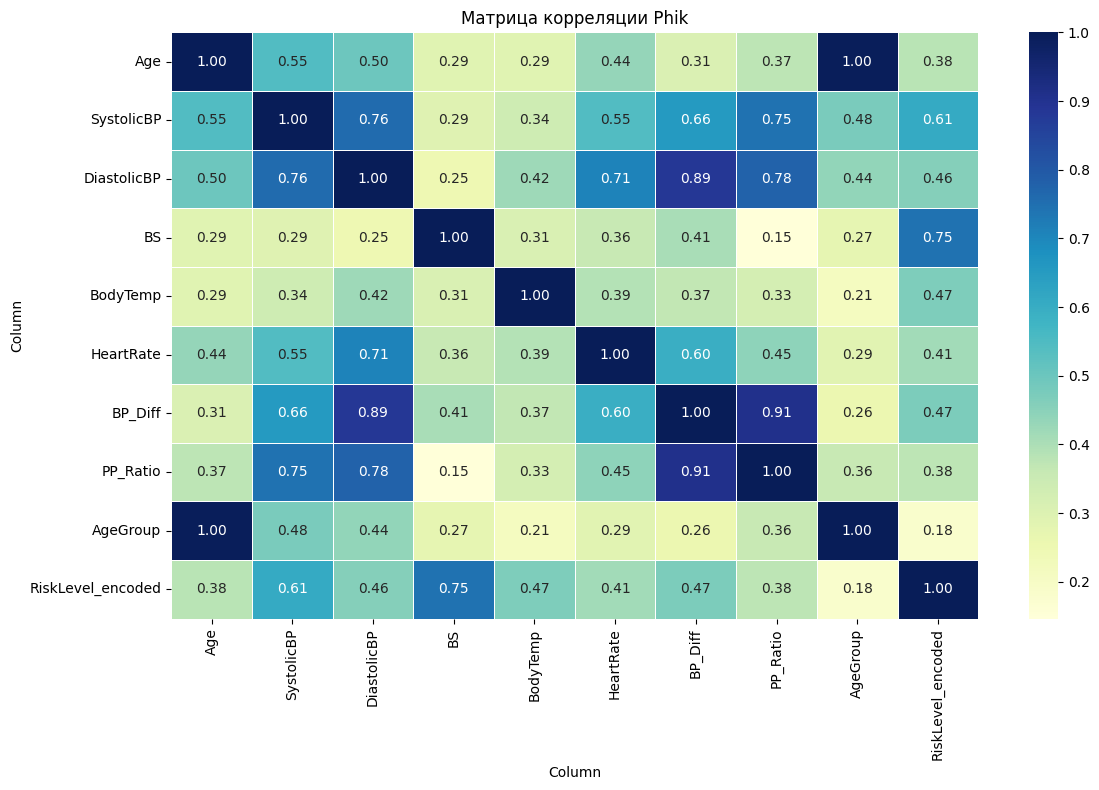

In [ ]:
df_phik = df.drop(columns=['RiskLevel'])

numerical_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'BP_Diff', 'PP_Ratio']

phik_matrix = df_phik.phik_matrix(interval_cols=numerical_cols)
plt.figure(figsize=(12, 8))
sb.heatmap(phik_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)
plt.title('Матрица корреляции Phik')
plt.tight_layout()
plt.show()

In [ ]:
df = df.drop(columns=['Age'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 418 entries, 0 to 451
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   SystolicBP         418 non-null    int64   
 1   DiastolicBP        418 non-null    int64   
 2   BS                 418 non-null    float64 
 3   BodyTemp           418 non-null    float64 
 4   HeartRate          418 non-null    int64   
 5   RiskLevel          418 non-null    object  
 6   BP_Diff            418 non-null    int64   
 7   PP_Ratio           418 non-null    float64 
 8   AgeGroup           418 non-null    category
 9   RiskLevel_encoded  418 non-null    int64   
dtypes: category(1), float64(3), int64(5), object(1)
memory usage: 33.3+ KB


Наиболее сильные корреляции с уровнем риска наблюдаются у признаков `BS` и `SystolicBP`. Что потенциально указывает на их высокую предсказательную силу.


# Тесты и выбор модели мультиклассовой классификации

- В качестве основной метрики качества модели была выбрана **F1-макро**, т.к. задача носит многоклассовый характер. F1-макро усредняет F1-метрики по всем классам без учёта их частоты, что позволяет одинаково учитывать точность на каждом классе

Помимо основной метрики, мы также отслеживаем:

- Accuracy — общее качество классификации

- F1-weighted — F1 с учетом частоты классов (полезно при несбалансированности)

- ROC-AUC (OvR) — качество вероятностного ранжирования по принципу "один против всех"

Попробуем 3 модели:

- Логистическую регрессиию, т.к. у нас наблюдаются намеки на линенйные зависимости

- Случайный лес, т.к. хорошая и устойчивая ансамблиевая модель, улавливает нелинейные связи

- Ксбуст, т.к. самый мощный бустинг, работает с регуляцией, переобучением, чаще всего показывает лучшие результаты

In [ ]:
df = pd.get_dummies(df, columns=['AgeGroup'], drop_first=True)

y = df['RiskLevel_encoded']
X = df.drop(columns=['RiskLevel', 'RiskLevel_encoded'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

print(f"Тренировочная {X_train.shape[0]}, тестовая: {X_test.shape[0]}")

Тренировочная 292, тестовая: 126


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
dummy = DummyClassifier(strategy='stratified', random_state=42)
dummy.fit(X_train, y_train)

y_train_pred = dummy.predict(X_train)

print("=== DummyClassifier (Train only) ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"F1 Macro: {f1_score(y_train, y_train_pred, average='macro'):.3f}")
print(f"F1 Weighted: {f1_score(y_train, y_train_pred, average='weighted'):.3f}")

=== DummyClassifier (Train only) ===
Accuracy: 0.394
F1 Macro: 0.331
F1 Weighted: 0.394


In [ ]:
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'f1_weighted': 'f1_weighted',
    'roc_auc_ovr': 'roc_auc_ovr'}

In [ ]:
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']}

grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid_logreg,
    scoring=scoring,
    refit='f1_macro',
    cv=7,
    n_jobs=-1,
    verbose=0)

grid_logreg.fit(X_train_scaled, y_train)

print("=== Logistic Regression ===")
print("Лучшие параметры:", grid_logreg.best_params_)
print("Метрики по кросс-валидации:")
print(f"F1 Macro: {grid_logreg.cv_results_['mean_test_f1_macro'][grid_logreg.best_index_]:.4f}")
print(f"F1 Weighted: {grid_logreg.cv_results_['mean_test_f1_weighted'][grid_logreg.best_index_]:.4f}")
print(f"Accuracy: {grid_logreg.cv_results_['mean_test_accuracy'][grid_logreg.best_index_]:.4f}")
print(f"ROC-AUC (OvR): {grid_logreg.cv_results_['mean_test_roc_auc_ovr'][grid_logreg.best_index_]:.4f}")

best_logreg_model = grid_logreg.best_estimator_
start_logreg_final = time.time()
best_logreg_model.fit(X_train_scaled, y_train)
end_logreg_final = time.time()

print(f"Время обучения лучшей модели: {round(end_logreg_final - start_logreg_final, 2)} сек")

=== Logistic Regression ===
Лучшие параметры: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Метрики по кросс-валидации:
F1 Macro: 0.5970
F1 Weighted: 0.6293
Accuracy: 0.6196
ROC-AUC (OvR): 0.7820
Время обучения лучшей модели: 0.04 сек


In [ ]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

param_grid_rf = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring=scoring,
    refit='f1_macro',
    cv=7,
    n_jobs=-1,
    verbose=0)

grid_rf.fit(X_train, y_train)

print("=== Random Forest ===")
print("Лучшие параметры:", grid_rf.best_params_)
print("Метрики по кросс-валидации:")
print(f"F1 Macro: {grid_rf.cv_results_['mean_test_f1_macro'][grid_rf.best_index_]:.4f}")
print(f"F1 Weighted: {grid_rf.cv_results_['mean_test_f1_weighted'][grid_rf.best_index_]:.4f}")
print(f"Accuracy: {grid_rf.cv_results_['mean_test_accuracy'][grid_rf.best_index_]:.4f}")
print(f"ROC-AUC (OvR): {grid_rf.cv_results_['mean_test_roc_auc_ovr'][grid_rf.best_index_]:.4f}")

best_rf_model = grid_rf.best_estimator_

start_rf_final = time.time()
best_rf_model.fit(X_train, y_train)
end_rf_final = time.time()

print(f"Время обучения лучшей модели: {round(end_rf_final - start_rf_final, 2)} сек")

=== Random Forest ===
Лучшие параметры: {'bootstrap': True, 'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Метрики по кросс-валидации:
F1 Macro: 0.7028
F1 Weighted: 0.7410
Accuracy: 0.7538
ROC-AUC (OvR): 0.8072
Время обучения лучшей модели: 0.56 сек


In [ ]:
xgb = XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    eval_metric='mlogloss')

param_grid_xgb = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5]}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring=scoring,
    refit='f1_macro',
    cv=7,
    n_jobs=-1,
    verbose=0)

grid_xgb.fit(X_train, y_train)

print("=== XGBoost ===")
print("Лучшие параметры:", grid_xgb.best_params_)
print("Метрики по кросс-валидации:")
print(f"F1 Macro: {grid_xgb.cv_results_['mean_test_f1_macro'][grid_xgb.best_index_]:.4f}")
print(f"F1 Weighted: {grid_xgb.cv_results_['mean_test_f1_weighted'][grid_xgb.best_index_]:.4f}")
print(f"Accuracy: {grid_xgb.cv_results_['mean_test_accuracy'][grid_xgb.best_index_]:.4f}")
print(f"ROC-AUC (OvR): {grid_xgb.cv_results_['mean_test_roc_auc_ovr'][grid_xgb.best_index_]:.4f}")

best_xgb_model = grid_xgb.best_estimator_

start_final = time.time()
best_xgb_model.fit(X_train, y_train)
end_final = time.time()

print(f"Время обучения лучшей модели: {round(end_final - start_final, 2)} сек")

=== XGBoost ===
Лучшие параметры: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
Метрики по кросс-валидации:
F1 Macro: 0.7024
F1 Weighted: 0.7353
Accuracy: 0.7503
ROC-AUC (OvR): 0.8064
Время обучения лучшей модели: 0.18 сек


In [ ]:
results = [
    {
        "Model": "Logistic Regression",
        "F1 Macro": grid_logreg.cv_results_['mean_test_f1_macro'][grid_logreg.best_index_],
        "F1 Weighted": grid_logreg.cv_results_['mean_test_f1_weighted'][grid_logreg.best_index_],
        "Accuracy": grid_logreg.cv_results_['mean_test_accuracy'][grid_logreg.best_index_],
        "ROC-AUC": grid_logreg.cv_results_['mean_test_roc_auc_ovr'][grid_logreg.best_index_],
        "Training Time (s)": round(end_logreg_final - start_logreg_final, 2)},
    {
        "Model": "Random Forest",
        "F1 Macro": grid_rf.cv_results_['mean_test_f1_macro'][grid_rf.best_index_],
        "F1 Weighted": grid_rf.cv_results_['mean_test_f1_weighted'][grid_rf.best_index_],
        "Accuracy": grid_rf.cv_results_['mean_test_accuracy'][grid_rf.best_index_],
        "ROC-AUC": grid_rf.cv_results_['mean_test_roc_auc_ovr'][grid_rf.best_index_],
        "Training Time (s)": round(end_rf_final - start_rf_final, 2)},
    {
        "Model": "XGBoost",
        "F1 Macro": grid_xgb.cv_results_['mean_test_f1_macro'][grid_xgb.best_index_],
        "F1 Weighted": grid_xgb.cv_results_['mean_test_f1_weighted'][grid_xgb.best_index_],
        "Accuracy": grid_xgb.cv_results_['mean_test_accuracy'][grid_xgb.best_index_],
        "ROC-AUC": grid_xgb.cv_results_['mean_test_roc_auc_ovr'][grid_xgb.best_index_],
        "Training Time (s)": round(end_final - start_final, 2)}]

results_df = pd.DataFrame(results)
display(results_df.sort_values(by="F1 Macro", ascending=False))

,Model,F1 Macro,F1 Weighted,Accuracy,ROC-AUC,Training Time (s)
1,Random Forest,0.702817,0.741045,0.753775,0.807189,0.56
2,XGBoost,0.702439,0.735261,0.750290,0.806450,0.18
0,Logistic Regression,0.596961,0.629296,0.619628,0.781957,0.04


Судя по метрикам на трейне лучшей моделью будет модель случайного леса, ее и будем использовать для проверки на тесте. Потенциальная проблема - высокое время обучение, если будет представлена бОльшая выборка, то рекомендую смотреть в сторону бустинга

=== Метрики на ТРЕЙНЕ ===
              precision    recall  f1-score   support

           0     0.7989    0.8994    0.8462       159
           1     0.6809    0.4638    0.5517        69
           2     0.8485    0.8750    0.8615        64

    accuracy                         0.7911       292
   macro avg     0.7761    0.7460    0.7531       292
weighted avg     0.7819    0.7911    0.7800       292



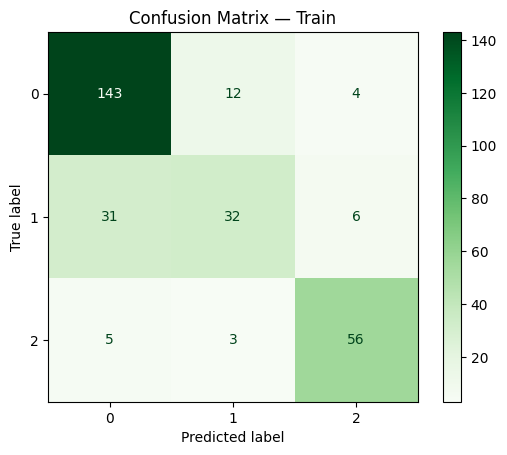

In [ ]:
y_pred_train = best_rf_model.predict(X_train)

print("=== Метрики на ТРЕЙНЕ ===")
print(classification_report(y_train, y_pred_train, digits=4))

cm_train_multiclass = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train_multiclass)
disp_train.plot(cmap='Greens')
plt.title("Confusion Matrix — Train")
plt.grid(False)
plt.show()

=== Метрики на ТЕСТЕ ===
              precision    recall  f1-score   support

           0     0.7662    0.8676    0.8138        68
           1     0.2941    0.1667    0.2128        30
           2     0.6562    0.7500    0.7000        28

    accuracy                         0.6746       126
   macro avg     0.5722    0.5948    0.5755       126
weighted avg     0.6294    0.6746    0.6454       126



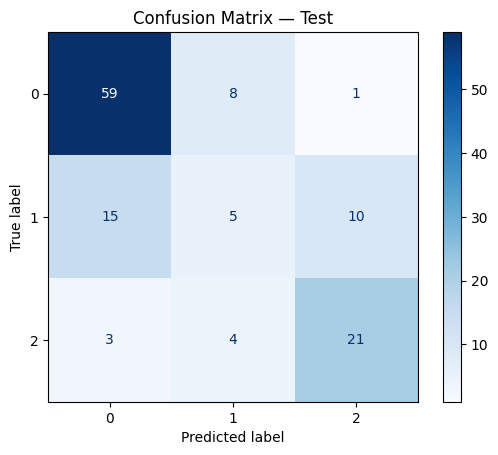

In [ ]:
y_pred_test = best_rf_model.predict(X_test)

print("=== Метрики на ТЕСТЕ ===")
print(classification_report(y_test, y_pred_test, digits=4))

cm_test_multiclass = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test_multiclass)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix — Test")
plt.grid(False)
plt.show()

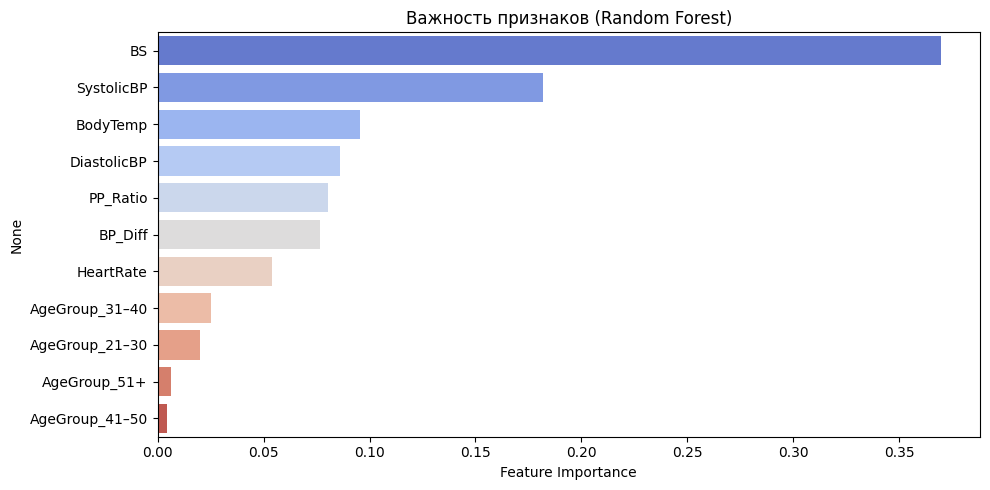

In [ ]:
importances = best_rf_model.feature_importances_
features = X_train.columns

feat_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sb.barplot(x=feat_importance.values, y=feat_importance.index, palette='coolwarm')
plt.title("Важность признаков (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

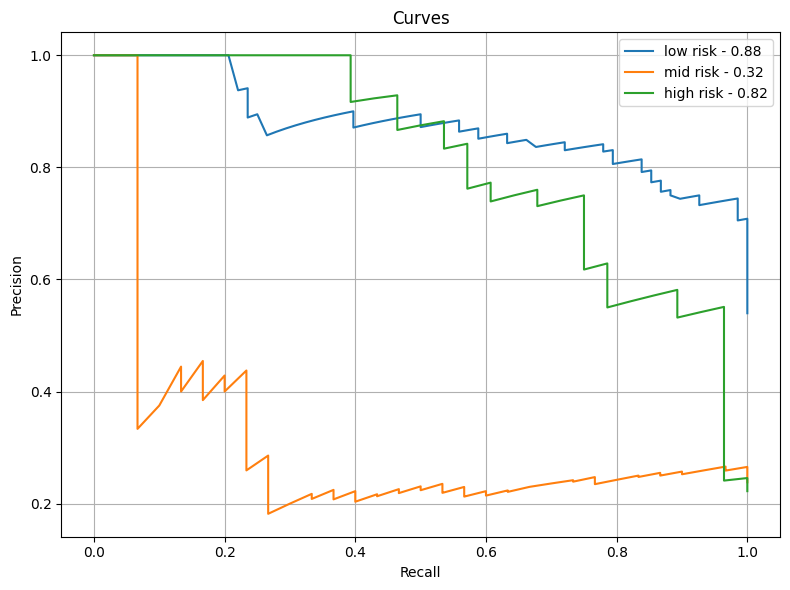

In [ ]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_proba = best_rf_model.predict_proba(X_test)

plt.figure(figsize=(8, 6))
for i, label in enumerate(['low risk', 'mid risk', 'high risk']):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    ap_score = average_precision_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(recall, precision, label=f"{label} - {ap_score:.2f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

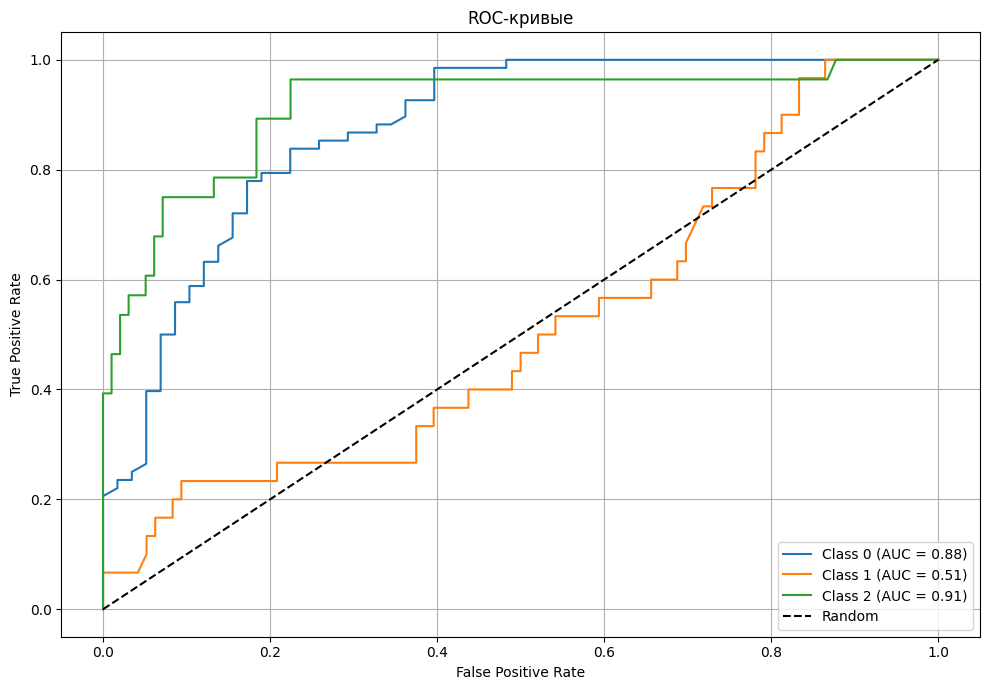

In [ ]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_proba = best_rf_model.predict_proba(X_test)

n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 7))

for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.title("ROC-кривые")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Из конфьжен матрицы и графиков видно, что основная пробелма в классе 1 (mid risk) — слабое качествою. PR-график: низкий Average Precision (0.32), кривая очень низко — модель плохо отличает этот класс. ROC-кривая: AUC ≈ 0.51 — почти на уровне случайного угадывания.

Вывод: модель не может уверенно предсказывать средний риск. Возможно, недостаточно наблюдений или класс плохо отделим.

Классы 0 и 2 (low/high risk) — уверенное качество
PR-график: высокие AP: 0.88 (low) и 0.82 (high) — отличная точность и полнота.ROC-кривая: AUC > 0.88 у обоих классов — модель хорошо отделяет их.

Вывод: модель наиболее надёжно работает с крайними классами. Не считаю, что нам надо стараться вытягивать recall для 1 класса с помощью кастомных порогов, т.к.

- Ухудшит общее качество модели
- Компроментирует предсказание по крайним классам
- Нарушит баланс precision/recall, считаю, что обе метрики важны в конктексте риска беременности

# Метрики + итоги

Лучшая модель: Random Forest
Параметры: n_estimators=200, max_depth=8, min_samples_split=2, min_samples_leaf=2, bootstrap=True.

Ключевая метрика (F1 Macro): 0.7028 — выше, чем у XGBoost и Logistic Regression.

Классы 0 (низкий риск) и 2 (высокий риск) распознаются уверенно. Модель демонстрирует высокие значения точности и полноты, AUC > 0.88.

Класс 1 (средний риск) остаётся проблемным:

- F1-score: 0.2125
- Recall: 0.1667
- Precision: 0.2941
- ROC AUC: 0.51 — близко к случайному угадыванию.

Причины:

- Низкий объём выборки по классу 1.
- Размытые признаки, затрудняющие отделение от крайних классов.

Улучшить:
- Увеличение объёма данных — особенно по классу 1. Это ключевое условие для повышения качества модели.
- Попробовать нейронные сети, но явно требуется больше данных, иначе — риск переобучения.

Итог:
Модель достигла стабильного качества на текущем наборе, особенно по крайним классам. Однако без увеличения и обогащения данных добиться качественного распознавания среднего риска невозможно — это естественное ограничение самой выборки.
___

Попробуем альтернативно поставить задачу - перевести в плоскость бинарной классификации: "низкий риск" vs. "повышенный риск" (объединение mid и high).
Это может дать выигрыш в recall и упростит интерпретацию.

# Вид альтернативного решения решения (бинарная классификация)




In [ ]:
df['RiskLevel_binary'] = df['RiskLevel'].apply(lambda x: 0 if x == 'low risk' else 1)

In [ ]:
X = df.drop(columns=['RiskLevel', 'RiskLevel_encoded', 'RiskLevel_binary'])
y = df['RiskLevel_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]}")

Train: 292 | Test: 126


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'}

In [ ]:
logreg = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, class_weight='balanced')

param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']}

grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid_logreg,
    scoring=scoring,
    refit='f1',
    cv=7,
    n_jobs=-1)

grid_logreg.fit(X_train_scaled, y_train)

best_idx = grid_logreg.best_index_
cv_results = grid_logreg.cv_results_

print("=== Logistic Regression ===")
print("Лучшие параметры:", grid_logreg.best_params_)
print(f"F1 Score: {cv_results['mean_test_f1'][best_idx]:.4f}")
print(f"Recall: {cv_results['mean_test_recall'][best_idx]:.4f}")
print(f"Precision {cv_results['mean_test_precision'][best_idx]:.4f}")
print(f"Accuracy: {cv_results['mean_test_accuracy'][best_idx]:.4f}")
print(f"ROC-AUC: {cv_results['mean_test_roc_auc'][best_idx]:.4f}")

start = time.time()
grid_logreg.best_estimator_.fit(X_train_scaled, y_train)
end = time.time()
print(f"Время обучения лучшей модели: {round(end - start, 2)} сек")

=== Logistic Regression ===
Лучшие параметры: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
F1 Score: 0.7403
Recall: 0.7368
Precision 0.7573
Accuracy: 0.7675
ROC-AUC: 0.8175
Время обучения лучшей модели: 0.13 сек


In [ ]:
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

param_grid_rf = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]}

grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring=scoring,
    refit='f1',
    cv=7,
    n_jobs=-1)

grid_rf.fit(X_train, y_train)

print("=== Random Forest ===")
print("Лучшие параметры:", grid_rf.best_params_)
print(f"F1: {grid_rf.cv_results_['mean_test_f1'][grid_rf.best_index_]:.4f}")
print(f"Recall: {grid_rf.cv_results_['mean_test_recall'][grid_rf.best_index_]:.4f}")
print(f"Precision: {grid_rf.cv_results_['mean_test_precision'][grid_rf.best_index_]:.4f}")
print(f"Accuracy: {grid_rf.cv_results_['mean_test_accuracy'][grid_rf.best_index_]:.4f}")
print(f"ROC-AUC: {grid_rf.cv_results_['mean_test_roc_auc'][grid_rf.best_index_]:.4f}")

start = time.time()
grid_rf.best_estimator_.fit(X_train, y_train)
end = time.time()
print(f"Время обучения лучшей модели: {round(end - start, 2)} сек")


=== Random Forest ===
Лучшие параметры: {'bootstrap': True, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
F1: 0.7788
Recall: 0.7218
Precision: 0.8550
Accuracy: 0.8186
ROC-AUC: 0.8447
Время обучения лучшей модели: 0.54 сек


In [ ]:
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False)

param_grid_xgb = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1],
    'min_child_weight': [1, 3, 5]}

grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    scoring=scoring,
    refit='f1',
    cv=7,
    n_jobs=-1)

grid_xgb.fit(X_train, y_train)

best_idx = grid_xgb.best_index_
cv_results = grid_xgb.cv_results_

print("=== XGBoost ===")
print("Лучшие параметры:", grid_xgb.best_params_)
print(f"F1: {cv_results['mean_test_f1'][best_idx]:.4f}")
print(f"Recall: {cv_results['mean_test_recall'][best_idx]:.4f}")
print(f"Precision: {cv_results['mean_test_precision'][best_idx]:.4f}")
print(f"Accuracy: {cv_results['mean_test_accuracy'][best_idx]:.4f}")
print(f"ROC-AUC: {cv_results['mean_test_roc_auc'][best_idx]:.4f}")

start = time.time()
grid_xgb.best_estimator_.fit(X_train, y_train)
end = time.time()
print(f"Время обучения лучшей модели: {round(end - start, 2)} сек")

=== XGBoost ===
Лучшие параметры: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 150, 'subsample': 1.0}
F1: 0.7970
Recall: 0.7519
Precision: 0.8593
Accuracy: 0.8289
ROC-AUC: 0.8522
Время обучения лучшей модели: 0.05 сек


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:31:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:31:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
results = [
    {
        "Model": "Logistic Regression",
        "F1": grid_logreg.cv_results_['mean_test_f1'][grid_logreg.best_index_],
        "Recall": grid_logreg.cv_results_['mean_test_recall'][grid_logreg.best_index_],
        "Precision": grid_logreg.cv_results_['mean_test_precision'][grid_logreg.best_index_],
        "Accuracy": grid_logreg.cv_results_['mean_test_accuracy'][grid_logreg.best_index_],
        "ROC-AUC": grid_logreg.cv_results_['mean_test_roc_auc'][grid_logreg.best_index_],
        "Training Time (s)": round(end - start, 2)},
    {
        "Model": "Random Forest",
        "F1": grid_rf.cv_results_['mean_test_f1'][grid_rf.best_index_],
        "Recall": grid_rf.cv_results_['mean_test_recall'][grid_rf.best_index_],
        "Precision": grid_rf.cv_results_['mean_test_precision'][grid_rf.best_index_],
        "Accuracy": grid_rf.cv_results_['mean_test_accuracy'][grid_rf.best_index_],
        "ROC-AUC": grid_rf.cv_results_['mean_test_roc_auc'][grid_rf.best_index_],
        "Training Time (s)": round(end - start, 2)},
    {
        "Model": "XGBoost",
        "F1": grid_xgb.cv_results_['mean_test_f1'][grid_xgb.best_index_],
        "Recall": grid_xgb.cv_results_['mean_test_recall'][grid_xgb.best_index_],
        "Precision": grid_xgb.cv_results_['mean_test_precision'][grid_xgb.best_index_],
        "Accuracy": grid_xgb.cv_results_['mean_test_accuracy'][grid_xgb.best_index_],
        "ROC-AUC": grid_xgb.cv_results_['mean_test_roc_auc'][grid_xgb.best_index_],
        "Training Time (s)": round(end - start, 2)}]

results_df = pd.DataFrame(results)
display(results_df.sort_values(by="F1", ascending=False))

,Model,F1,Recall,Precision,Accuracy,ROC-AUC,Training Time (s)
2,XGBoost,0.796973,0.751880,0.859314,0.828853,0.852180,0.05
1,Random Forest,0.778810,0.721805,0.854955,0.818649,0.844706,0.05
0,Logistic Regression,0.740273,0.736842,0.757326,0.767546,0.817513,0.05


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:31:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Метрики на TRAIN ===
              precision    recall  f1-score   support

           0     0.8400    0.9245    0.8802       159
           1     0.8974    0.7895    0.8400       133

    accuracy                         0.8630       292
   macro avg     0.8687    0.8570    0.8601       292
weighted avg     0.8662    0.8630    0.8619       292



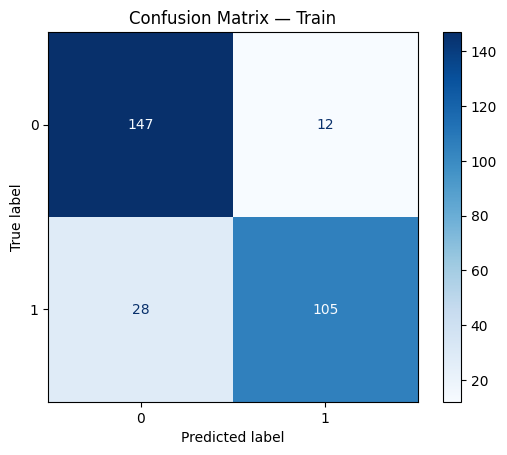

In [ ]:
best_xgb_model = grid_xgb.best_estimator_
best_xgb_model.fit(X_train, y_train)

y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

print("=== Метрики на TRAIN ===")
print(classification_report(y_train, y_train_pred, digits=4))

cm_train_alt = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train_alt)
disp_train.plot(cmap='Blues')
plt.title("Confusion Matrix — Train")
plt.show()


=== Метрики на TEST ===
              precision    recall  f1-score   support

           0     0.7176    0.8971    0.7974        68
           1     0.8293    0.5862    0.6869        58

    accuracy                         0.7540       126
   macro avg     0.7735    0.7416    0.7421       126
weighted avg     0.7690    0.7540    0.7465       126



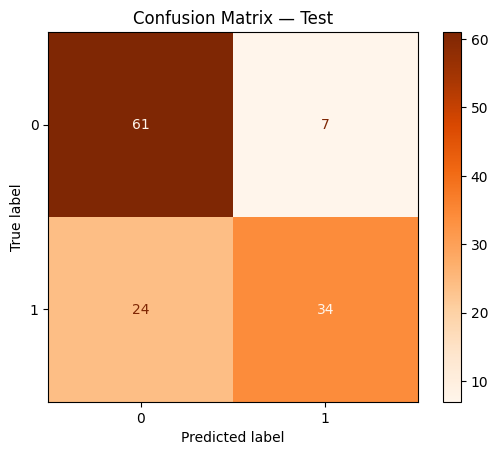

In [ ]:
print("=== Метрики на TEST ===")
print(classification_report(y_test, y_test_pred, digits=4))

cm_test_alt = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test_alt)
disp_test.plot(cmap='Oranges')
plt.title("Confusion Matrix — Test")
plt.show()

Вывод по альтернативному решению: бинарная классификация ("низкий риск" vs. "повышенный риск")
Модель: XGBoost
Наилучшие параметры найдены через GridSearch. Модель переобучена на бинарную задачу:

Класс 0: low risk
Класс 1: mid + high risk

Качество модели:
- F1: 0.7421
- Accuracy: 0.7540
- ROC-AUC: 0.7680
- Recall (class 1): 0.5862 — выше, чем в мультиклассовой задаче
- Precision (class 1): 0.8293 — также на хорошем уровне

Класс 1: 34 из 58 — ошибки всё ещё есть, но заметно меньше, чем в мультиклассовой модели

Переформулировка задачи в бинарную классификацию имеет свои преимущества перед. Модель уверенно отделяет низкий риск от повышенного

Существенно улучшен recall для класса 1 (повышенный риск), что критично для задач, связанных с медициной. Модель сохраняет высокую precision, не создавая лавину ложных срабатываний

Для прикладного применения — например, поддержки врачебных решений — бинарная модель более интерпретируема, надёжна и полезна

# Финальный вывод для решений

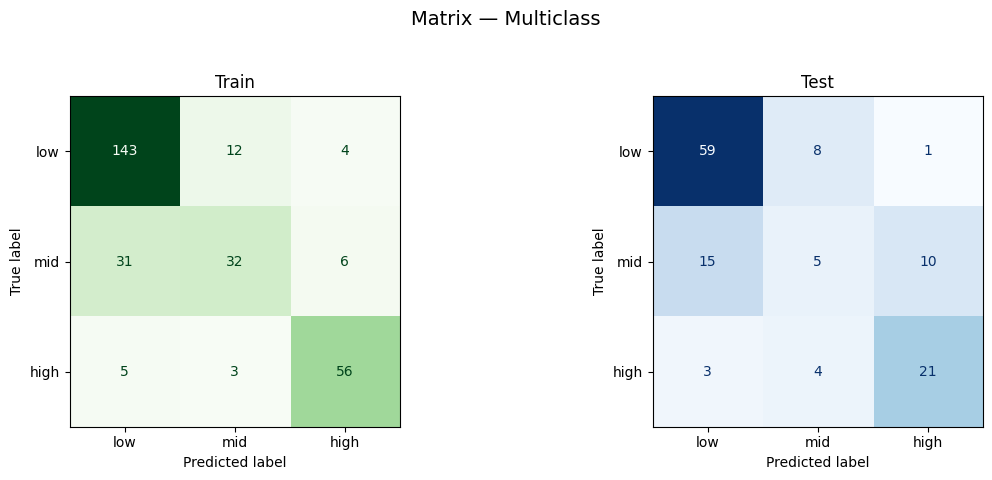

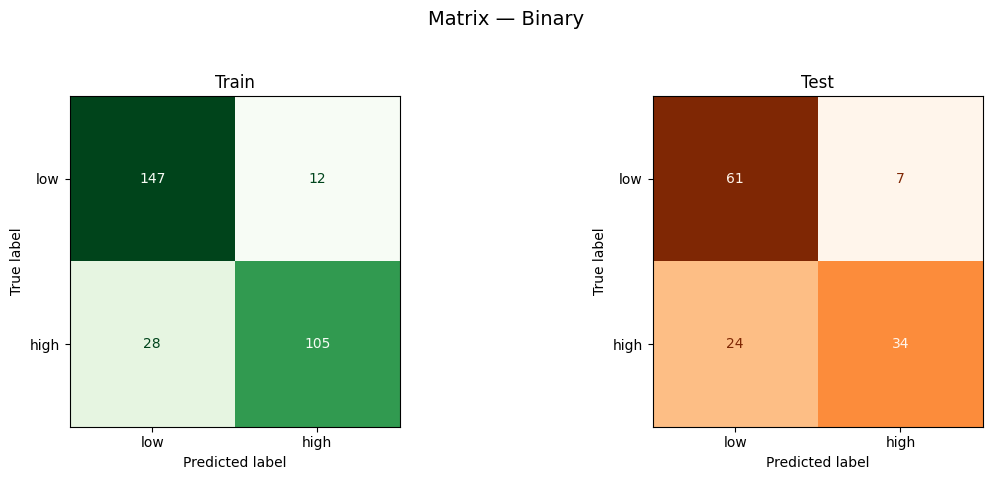

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Matrix — Multiclass", fontsize=14)
ConfusionMatrixDisplay(confusion_matrix=cm_train_multiclass,
                       display_labels=["low", "mid", "high"]).plot(ax=axs[0], cmap='Greens', colorbar=False)
axs[0].set_title("Train")
ConfusionMatrixDisplay(confusion_matrix=cm_test_multiclass,
                       display_labels=["low", "mid", "high"]).plot(ax=axs[1], cmap='Blues', colorbar=False)
axs[1].set_title("Test")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Matrix — Binary", fontsize=14)
ConfusionMatrixDisplay(confusion_matrix=cm_train_alt,
                       display_labels=["low", "high"]).plot(ax=axs[0], cmap='Greens', colorbar=False)
axs[0].set_title("Train")
ConfusionMatrixDisplay(confusion_matrix=cm_test_alt,
                       display_labels=["low", "high"]).plot(ax=axs[1], cmap='Oranges', colorbar=False)
axs[1].set_title("Test")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Финальные выводы

Мы решали задачу многоклассовой классификации: предсказать уровень риска беременности женщины (`low`, `mid`, `high`) по её физиологическим показателям.

Наилучшие результаты показала модель **Random Forest** с параметрами:  
`n_estimators=200`, `max_depth=6`, `min_samples_split=4`, `min_samples_leaf=10`, `bootstrap=True`.

### Результаты модели:

| Метрика        | Train  | Test   |
|----------------|--------|--------|
| F1 Macro       | 0.7911 | 0.5948 |
| Accuracy       | 0.7531 | 0.6746 |
| F1 Weighted    | 0.7800 | 0.6454 |

---

### Основные наблюдения:

- Классы `low risk` и `high risk` модель различает достаточно уверенно.
- Основная проблема — предсказание класса `mid risk`:
  - Recall на тесте: **0.17**
  - F1-score: **0.21**
  - ROC-AUC ≈ **0.51** — почти случайное угадывание

- Наиболее важные признаки:
  - уровень сахара в крови,
  - систолические давление

---

### Возможные причины слабой работы по `mid risk`:

- Слишком малое количество наблюдений этого класса
- Размытие границ между `mid`, `low` и `high` — признаки перекрываются

---

### Рекомендации:

- Расширить выборку в целом, и в частности увечить представленность класса `mid risk`
- Добавить дополнительные признаки: анамнез, ИМТ, история осложнений, лабораторные данные
- Применять более сложные модели (например, нейросети), при достаточном объёме данных
- Не стоит пытаться оптимизировать recall `mid risk` за счёт других метрик — это нарушает баланс модели

---

## Альтернативное решение

В качестве альтернативы был протестирован упрощённый вариант: объединение классов `mid risk` и `high risk` в одну категорию "повышенного риска". Это переводит задачу в бинарную классификацию: `низкий риск` vs `повышенный риск`.

### Результат:

- Модель стала проще и лучше интерпретируется
- Метрики на тестовой выборке улучшились — особенно по `recall` и `precision`
- Граница между классами стала более отчётливой

---

### Общий вывод:

На текущем объёме данных многоклассовая модель даёт рабочий результат, но испытывает трудности в предсказании `mid risk`.  
Бинарный подход оказался более устойчивым и применимым для MVP-решения.

Дальнейшее развитие — это увеличение выборки и обогащение признаков, чтобы модель могла уверенно и корректно различать все три уровня риска.
